In [2]:
import glob
import csv
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
# !pip install funcy
# import funcy
# from funcy import print_durations
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from torch.cuda.amp import GradScaler
torch.backends.cudnn.benchmark = True
import datetime
import gc

In [4]:
start_date = '1980-01-01'

In [13]:
macro_df = pd.read_csv('macro_features_final.csv',index_col=0).loc[start_date:]
macro_df = macro_df.dropna(axis=0,how='all')
macro_df = macro_df.dropna(axis=1,how='all')
# features_idx = macro_df.columns
macro_df

,W875RX1,DPCERA3M086SBEA,CMRMTSPL,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,IPNCONGD,IPBUSEQ,...,RNA,ROA,ROE,SGA2S,D2A,AC,OA,OL,PCM,AT
rdq,,,,,,,,,,,,,,,,,,,,,
1980-01-26,4985.4,39.122,596439.789,52.1712,55.8565,54.1991,65.9046,44.8476,75.6224,30.9752,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.121469,0.064200,0.154266,0.620194,0.033420,0.009393,-0.001824,1.265149,-1.788297,191.9680
1980-02-23,4965.6,38.795,590829.499,52.1976,56.0214,54.5048,66.0877,44.5344,76.1270,31.1525,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.121540,0.063514,0.157833,0.623039,0.033588,0.011206,-0.001425,1.276434,-1.806736,195.4105
1980-03-29,4948.3,38.479,577376.228,51.9834,55.6418,54.1420,65.5822,43.7530,75.8414,30.8860,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30,14406.3,125.640,1572476.000,102.0374,101.2518,101.6865,100.8504,104.7309,99.7321,95.8557,...,0.049653,0.013872,0.069816,0.659218,0.022986,0.003672,-0.000196,0.474068,-0.202465,1124.9105
2021-12-31,14398.0,123.868,1562935.000,101.6402,100.7942,101.2701,100.2659,103.9276,99.2067,95.7659,...,0.049773,0.013892,0.069949,0.659782,0.022915,0.004113,-0.000202,0.475670,-0.205471,1131.1950
2022-01-31,14363.1,126.504,1594543.000,102.6863,101.8134,102.4001,101.8697,106.0272,100.6766,95.4291,...,0.049706,0.013879,0.070214,0.659905,0.022857,0.003672,-0.000198,0.478045,-0.212693,1136.5500


In [41]:
returns_df = pd.read_csv('returns.csv',index_col=0).loc[start_date:]
returns_df = returns_df.dropna(axis=0,how='all')
returns_df = returns_df.dropna(axis=1,how='all')
date_idx = returns_df.index
equity_idx = returns_df.columns
returns_df

,0081A,0091A,0099A,0127A,0138A,0146A,0153A,0183B,0223B,0230B,...,ZVXI,ZWRK,ZWS,ZXAIY,ZY,ZYME,ZYNE,ZYXI,ZZ,ZZ1
datadate,,,,,,,,,,,,,,,,,,,,,
1980-01-31,NaN,0.012579,NaN,0.068182,0.039548,NaN,NaN,NaN,0.007752,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.137500
1980-02-29,NaN,-0.006211,NaN,0.000000,NaN,NaN,NaN,NaN,-0.086462,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.164835
1980-03-31,NaN,-0.306250,NaN,0.007092,NaN,NaN,NaN,NaN,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.118421
1980-04-30,NaN,0.252252,NaN,-0.126761,NaN,NaN,NaN,NaN,0.139130,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.029851
1980-05-31,NaN,0.071942,NaN,0.177419,NaN,NaN,NaN,NaN,0.036336,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.123077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.002053,0.068746,0.636364,-0.195140,-0.233815,-0.096698,0.100088,NaN,NaN
2021-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.001025,-0.033076,0.001111,-0.145283,-0.096180,-0.096606,0.021548,NaN,NaN
2021-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.001026,0.038516,0.054384,-0.261589,-0.184983,-0.167630,-0.221094,NaN,NaN


In [14]:
feat_comb_df = pd.read_csv('features_full_final.csv').set_index(['tic','rdq']).drop(['FYEARQ','FQTR'],axis=1)
feat_comb_df = feat_comb_df.dropna(axis=0,how='all')
feat_comb_df = feat_comb_df.dropna(axis=1,how='all')
feat_comb_df = feat_comb_df[sorted(feat_comb_df.columns)]
feat_comb_df

A2ME        AC        AT       ATO      BEME      BETA  \
tic   rdq                                                                      
0081A 1996-12-31       NaN       NaN       NaN       NaN       NaN       NaN   
      1997-01-31       NaN       NaN       NaN       NaN       NaN       NaN   
      1997-02-28  0.564765       NaN   140.274       NaN       NaN       NaN   
      1997-03-31  0.564765       NaN   140.274       NaN       NaN       NaN   
      1997-04-30  0.529462       NaN   146.767       NaN       NaN       NaN   
...                    ...       ...       ...       ...       ...       ...   
ZZ    2012-10-31  5.840417  0.377852   971.509  0.888069 -0.316438  0.503049   
      2012-11-30  5.840417  0.377852   971.509  0.888069 -0.316438  0.503035   
      2012-12-31  5.840417  0.377852   971.509  0.888069 -0.316438  0.500307   
      2013-01-31  4.440987  0.489857  1005.345  1.081163 -0.253677  0.501021   
      2013-02-28  4.440987  0.489857  1005.345  1.081163 -0.253677  0.500922   

                         C  CF      CF2P       CTO  ...  REL2HIGH  RESID_VAR  \
tic   rdq                                           ...                        
0081A 1996-12-31       NaN NaN       NaN       NaN  ...       NaN        NaN   
      1997-01-31       NaN NaN       NaN       NaN  ...       NaN        NaN   
      1997-02-28  0.011328 NaN       NaN       NaN  ...       NaN   1.896184   
      1997-03-31  0.011328 NaN       NaN       NaN  ...       NaN   2.542292   
      1997-04-30  0.014431 NaN       NaN       NaN  ...       NaN   2.653953   
...                    ...  ..       ...       ...  ...       ...        ...   
ZZ    2012-10-31  0.091438 NaN -0.015174  0.549053  ...  0.910204   1.851362   
      2012-11-30  0.091438 NaN -0.015174  0.549053  ...  0.885714   0.619041   
      2012-12-31  0.091438 NaN -0.015174  0.549053  ...  0.885714   0.598993   
      2013-01-31  0.127473 NaN  0.042809  0.614895  ...  0.881633   0.542592   
      2013-02-28  0.127473 NaN  0.042809  0.614895  ...  0.889796   0.429795   

                       RNA       ROA       ROE       S2P     SGA2S   ST_REV  \
tic   rdq                                                                     
0081A 1996-12-31       NaN       NaN       NaN       NaN       NaN      NaN   
      1997-01-31       NaN       NaN       NaN       NaN       NaN      NaN   
      1997-02-28       NaN       NaN       NaN       NaN       NaN   1.5583   
      1997-03-31       NaN       NaN       NaN       NaN       NaN  10.7738   
      1997-04-30       NaN       NaN       NaN       NaN       NaN  -2.7778   
...                    ...       ...       ...       ...       ...      ...   
ZZ    2012-10-31  0.118627 -0.009920  0.167075  7.568810  0.818410  36.2500   
      2012-11-30  0.118627 -0.009920  0.167075  7.568810  0.818410   2.2936   
      2012-12-31  0.118627 -0.009920  0.167075  7.568810  0.818410  -2.6906   
      2013-01-31  0.167337  0.002145 -0.024645  5.954049  0.798554   0.0000   
      2013-02-28  0.167337  0.002145 -0.024645  5.954049  0.798554  -0.4608   

                       SUV  VARIANCE  
tic   rdq                             
0081A 1996-12-31       NaN       NaN  
      1997-01-31       NaN       NaN  
      1997-02-28       NaN  4.225542  
      1997-03-31       NaN  6.975184  
      1997-04-30       NaN  7.456677  
...                    ...       ...  
ZZ    2012-10-31  0.669890  4.256721  
      2012-11-30 -0.125130  0.458271  
      2012-12-31  0.062727  0.420686  
      2013-01-31 -1.501970  0.311550  
      2013-02-28 -0.227316  0.230933  

[3689185 rows x 45 columns]

In [15]:
feat_comb_df.shape, returns_df.shape, macro_df.shape

((3689185, 45), (506, 31140), (670, 159))

In [16]:
MIN_AVAILABLE_FEATURES = 15

full_df_lst = []
for date in tqdm(date_idx):
    sub = feat_comb_df.loc[feat_comb_df.index.get_level_values(1) < date]
    sub = sub.groupby(sub.index.get_level_values('tic')).last(1)
    sub = sub.transpose()
    
    sub = sub.rank(pct=True,axis=1)*2-1
    idx = (sub.isna().sum(axis=0) >= MIN_AVAILABLE_FEATURES).index
    sub = sub[idx].fillna(0)
    
#     sub = sub.fillna(sub.median(axis=1),axis=0)
    
    sub['date'] = date
    sub =  sub.set_index(['date',sub.index])
    
    full_df_lst.append(sub)

100%|██████████| 670/670 [18:23<00:00,  1.65s/it]


In [17]:
del(feat_comb_df)
gc.collect()

41

In [18]:
full_df_lst[0]

tic                       0138A     0223B     2788A     2793A     2824B  \
date                                                                      
1980-01-26 A2ME       -0.227189  0.588474  0.074991  0.739934 -0.384559   
           AC          0.000000  0.000000  0.000000  0.000000  0.587302   
           AT          0.239572  0.029900  0.538575 -0.553341 -0.802141   
           ATO        -0.415087 -0.749092  0.913675 -0.451392 -0.339250   
           BEME        0.000000  0.000000  0.000000  0.000000 -0.071429   
           BETA        0.000000  0.000000  0.000000  0.000000  0.000000   
           C          -0.905751 -0.440445 -0.827829 -0.559184 -0.778108   
           CF          0.000000  0.000000  0.000000  0.000000  0.000000   
           CF2P        0.000000  0.486111  0.000000  0.000000  0.000000   
           CTO        -0.228537 -0.725111  0.626763 -0.589682 -0.238210   
           D2A        -0.125893 -0.043430  0.000000  0.000000  0.000000   
           D2P        -0.630931  0.938428  0.818906 -0.630931 -0.034408   
           DPI2A      -0.378806  0.548518 -0.511977 -0.625660  0.403167   
           E2P         0.335514  0.355144  0.571792 -0.872774 -0.320974   
           FC2Y        0.000382  0.000382  0.000382  0.000382  0.000382   
           IDIOVOL     0.000000  0.000000  0.000000  0.000000  0.000000   
           INVESTMENT  0.618612 -0.371472 -0.563692 -0.863463 -0.606407   
           LEV        -0.017357  0.543748 -0.246900  0.491321 -0.588381   
           LME         0.331589 -0.314585  0.625245 -0.806409 -0.605625   
           LTURNOVER  -0.880314 -0.015043  0.937214  0.054938 -0.553303   
           LT_REV      0.001052 -0.426166 -0.330060  0.515959  0.163101   
           MKTBETA    -0.567983 -0.679832 -0.263894  0.317721 -0.804963   
           NI         -0.448454 -0.448454  0.296760  0.840206 -0.448454   
           NOA         0.403040  0.081201  0.537264 -0.629218 -0.738969   
           OA          0.000000  0.000000  0.000000  0.000000  0.000000   
           OL         -0.556086  0.000000 -0.381384  0.643914  0.792840   
           OP          0.000000  0.000000  0.000000  0.000000 -0.667954   
           PCM        -0.023198 -0.778790  0.616404 -0.836785 -0.761392   
           PM          0.502712  0.690446 -0.312474 -0.911556  0.120567   
           PROF        0.000000  0.000000  0.000000  0.000000  0.000000   
           Q           0.000000 -0.750000  0.000000  0.000000  0.000000   
           R12_2       0.375809 -0.715395 -0.492238 -0.633247  0.854463   
           R12_7      -0.290427 -0.346701 -0.672057 -0.111902  0.851229   
           R2_1       -0.080283 -0.066795  0.739884  0.249197  0.587026   
           R36_13     -0.025182 -0.085487 -0.043738 -0.267064  0.685222   
           REL2HIGH    0.464021 -0.520490  0.228783 -0.038399  0.749919   
           RESID_VAR   0.000000  0.000000  0.000000  0.000000  0.000000   
           RNA         0.078463 -0.368295  0.467574 -0.889512 -0.244195   
           ROA         0.500952 -0.427048  0.111619 -0.867429  0.009524   
           ROE         0.000000  0.000000  0.000000  0.000000 -0.492647   
           S2P        -0.327737  0.418978  0.086861  0.881752  0.288321   
           SGA2S      -0.766141  0.000000  0.412303  0.924759 -0.076767   
           ST_REV      0.329910 -0.686136  0.767651 -0.171053 -0.538511   
           SUV         0.000000  0.000000  0.000000  0.000000  0.000000   
           VARIANCE    0.000000  0.000000  0.000000  0.000000  0.000000   

tic                       2825B     2827B     2828B     2829B     2830B  ...  \
date                                                                     ...   
1980-01-26 A2ME        0.675656 -0.077207  0.597340 -0.387514  0.000000  ...   
           AC          0.000000 -0.468254  0.000000  0.000000  0.000000  ...   
           AT         -0.679587 -0.497231 -0.565891 -0.571798  0.000000  ...   
           ATO        -0.662767 -0.576442  0.132715 -0.942719  0.000000  .

In [19]:
orig = (83,360)
valid = (360,420)
test = (420,505)

# Train: 1984 to 2010
# Valid: 2010 to 2015
# Test: 2015 to 2022

In [79]:
class AEDataSet(torch.utils.data.Dataset):
    def __init__(self, macro_df, full_df_lst, returns_df, date_idx, start_i, end_i, rhs_input_assets=False,lag=1):
        self.full_df_lst = full_df_lst
        self.macro_df = macro_df
        self.returns_df = returns_df
        self.date_idx = date_idx
        self.start_i, self.end_i = start_i, end_i
        self.rhs_input_assets = rhs_input_assets
        self.epsilon=1e-5
        self.lag=lag
        
        self.output_date_idx = date_idx[start_i+lag:end_i]
        
    def __len__(self):
        return self.end_i - self.start_i - self.lag
    
    def __getitem__(self, idx):
        input_idx = idx
        idx += self.start_i+self.lag
        date = self.date_idx[idx] # returns date
        
        macro = self.macro_df[macro_df.index == date].to_numpy()
        
        mask = ~np.isnan(self.returns_df.loc[date].to_numpy())
        traded_assets_idx = self.returns_df.columns[mask]
        
        lhs = self.full_df_lst[idx - self.lag]
        lhs_idx = lhs.columns
        
        comb_idx = traded_assets_idx.intersection(lhs_idx)
        
        lhs = lhs.reindex(comb_idx,axis=1,fill_value=0).to_numpy()
        
        rhs_tmp = self.returns_df.loc[date,comb_idx]
        rhs_tmp = rhs_tmp.clip(rhs_tmp.quantile(0.01),rhs_tmp.quantile(0.99))
        output = rhs_tmp.to_numpy()

        lhs_tmp = np.concatenate([lhs,np.expand_dims(np.ones(lhs.shape[1]),0)],axis=0)
        macro_tmp = np.array(lhs.shape[1]*[macro.squeeze(0)])
        
        if self.rhs_input_assets:
            rhs = output
        else:
            try:
#                 rhs = (np.linalg.inv(lhs @ lhs.T) @ lhs) @ rhs_tmp
                # need to double check with KAi
                rhs = (np.linalg.inv(lhs_tmp @ lhs_tmp.T) @ lhs_tmp) @ rhs_tmp
#                 rhs = np.concatenate([rhs,[equal_weighted_portfolio]])
            except Exception as e:
                print("idx:",input_idx)
                print(e)
#                 return self.full_df_lst[idx - self.lag].reindex(traded_assets_idx,axis=1,fill_value=0), rhs_tmp
                # return lhs,lhs_tmp,output
                raise e
#             rhs.index = lhs_tmp.index
#             rhs = rhs.reindex(self.alpha_names,fill_value=0).clip(-5e4,5e4)
#             rhs['equal'] = equal_weighted_portfolio
#             rhs = rhs.to_numpy()
        return macro_tmp,lhs,rhs,output,comb_idx

In [80]:
def collate_fn(batch):

    len_x = [len(output) for macro,lhs,rhs,output,_ in batch]
    full_size = max(len_x)
#     print(full_size)
    
    # need to double check with KAi
    batch_macro = [nn.functional.pad(torch.Tensor(macro),pad=(0,full_size-macro.shape[1],0,0)) for macro,lhs,rhs,output,_ in batch]
    batch_lhs = [nn.functional.pad(torch.Tensor(lhs),pad=(0,full_size-lhs.shape[1],0,0)) for macro,lhs,rhs,output,_ in batch]
    batch_rhs = [torch.Tensor(rhs) for macro,lhs,rhs,output,_ in batch]
    batch_output = [nn.functional.pad(torch.Tensor(output),pad=(0,full_size-len(output))) for macro,lhs,rhs,output,_ in batch]
    batch_assets = [idx for macro,lhs,rhs,output,idx in batch]
    
    return torch.cat([x.unsqueeze(0) for x in batch_macro]),\
        torch.cat([x.unsqueeze(0) for x in batch_lhs]),\
        torch.cat([x.unsqueeze(0) for x in batch_rhs]),\
        torch.cat([x.unsqueeze(0) for x in batch_output]), torch.tensor(len_x), batch_assets

In [81]:
train_data = AEDataSet(macro_df,full_df_lst,returns_df,date_idx,48,360)
valid_data = AEDataSet(macro_df,full_df_lst,returns_df,date_idx,360,420)
test_data= AEDataSet(macro_df,full_df_lst,returns_df,date_idx,420,505)

In [82]:
len_lst = []
for i in range(len(valid_data)):
    macro,lhs,rhs,output,idx = valid_data[i]
    len_lst.append(lhs.shape[1])
    
print(macro.shape, lhs.shape, rhs.shape, output.shape,len(idx))

(3173, 159) (45, 3173) (46,) (3173,) 3173


<AxesSubplot:>

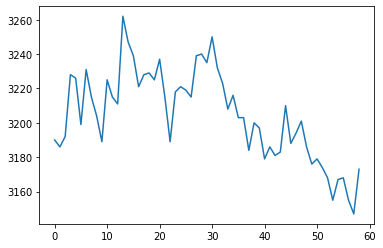

In [45]:
pd.Series(len_lst).plot()

In [47]:
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size = 2,
    pin_memory=True,
    num_workers=1,
    shuffle=True,
    collate_fn = collate_fn
)

In [49]:
train_loader